In [ ]:
!pip install torchmetrics
!pip install netCDF4
!pip install basemap
!pip install eofs

#Metrics

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from torchvision.utils import save_image
from torchmetrics.regression import PearsonCorrCoef
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof
from torch import nn

import netCDF4 as nc
import numpy as np
import torch

In [ ]:
# path = "/content/gdrive/MyDrive/AI_MTP_2/EC_Earth3_CC_historical_1850_2014.nc"

### OR ###

path = "/content/gdrive/MyDrive/AI_MTP_2/GISS-E2-1-H_historical_1850_2014.nc"


trY_SST_ds=nc.Dataset(path)

mask=1-trY_SST_ds.variables['sst'][0,0,0,:,:].mask

lat_sst=trY_SST_ds.variables['lat'][:]
lon_sst=trY_SST_ds.variables['lon'][:]

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/AI_MTP_2/GISS-E2-1-H_historical_1850_2014.nc'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def plot_map(lon, lat, data, file_name, min_lvl, max_lvl):

    m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(lat_sst), urcrnrlat=np.max(lat_sst),
            llcrnrlon=np.min(lon_sst), urcrnrlon=np.max(lon_sst), )

    lons, lats = np.meshgrid(lon, lat)
    x, y = m(lons, lats)

    # levels = np.linspace(min(np.unique(data)), max(np.unique(data)), 21)
    levels = np.linspace(min_lvl, max_lvl, 21)

    temp = m.contourf(x, y, data, levels=levels, cmap='seismic')
    cb = m.colorbar(temp,"bottom", size="15%", pad="10%")

    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(0., 361., 45.), labels=[0, 0, 0, 1])
    #plt.title('sst')
    #cb.set_label('sst')

    plt.savefig(file_name)
    plt.show()
    # plt.clf()




def plot_map_metric(lon,lat,data,file_name):

    m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(lat_sst), urcrnrlat=np.max(lat_sst),
            llcrnrlon=np.min(lon_sst), urcrnrlon=np.max(lon_sst), )

    lons,lats= np.meshgrid(lon,lat)
    x,y = m(lons,lats)
    levels = np.linspace(min(np.unique(data)),max(np.unique(data)),21)
    temp = m.contourf(x,y,data,levels=levels,cmap='Spectral')
    cb = m.colorbar(temp,"bottom", size="15%", pad="10%")

    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(0., 361., 45.), labels=[0, 0, 0, 1])
    #plt.title('sst')
    #cb.set_label('sst')

    plt.savefig(file_name)
    plt.show()
    # plt.clf()



def EOF(Data, lat, lon):
    wgts   = np.cos(np.deg2rad(lat))
    wgts   = wgts.reshape(len(wgts), 1)
    #solver1 = Eof(np.array(ser_original[6]), weights=wgts)

    coslat = np.cos(np.deg2rad(lat))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver =Eof(Data,weights=wgts)
    eof1=solver.eofs()

    pc=solver.pcs(pcscaling=1)
    varfrac=solver.varianceFraction()
    lambdas=solver.eigenvalues()


    parallels = np.arange(-90,90,20)
    meridians = np.arange(-180,180,40)

    fig=plt.figure(figsize=(10,16))

    m=Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat),
            urcrnrlon=max(lon), urcrnrlat=max(lat), resolution='l')
    x, y = m(*np.meshgrid(lon,lat))
    clevs = np.linspace(-0.1,0.1,11)

    cs = m.contourf(x,y,eof1[0,:,:].squeeze(),clevs,cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.fillcontinents(color='#000000',lake_color='#99ffff')
    m.drawparallels(parallels,labels=[1,0,0,0])
    m.drawmeridians(meridians,labels=[1,0,0,1])

    cb=m.colorbar(cs, 'bottom', size='5%',pad='10%')
    #cb.set_label('EOF', fontsize=10)
    plt.title('EOF1', fontsize=15)
    plt.show()




pearson=PearsonCorrCoef().to(device)
Loss = nn.MSELoss()



def save_some_examples(gen, val_loader, epoch, folder='/kaggle/working'):

    y_fake_list=[]

    y_list=[]
    for x in val_loader:
        y = x
        x, y = x.float().to(device), y.float().to(device)
        gen.eval()
        with torch.no_grad():
            y_fake, _ = gen(x.float())

            # print(y_fake.shape)

            y_fake_list.extend(y_fake.cpu().detach().numpy())
            y_list.extend(y.cpu().detach().numpy())


    y_fake_list=np.array(y_fake_list) #* (trY_SST_max-trY_SST_min)+trY_SST_min
    y_list=np.array(y_list) #* (trY_SST_max-trY_SST_min)+trY_SST_min

    y_fake=torch.Tensor(y_fake_list).squeeze().to(device)

    y=torch.Tensor(y_list).squeeze().to(device)


    corr_list=np.zeros(shape=(y.shape[1],y.shape[2]))
    loss_list=np.zeros(shape=(y.shape[1],y.shape[2]))


    for i in range(y.shape[1]):
        for j in range(y.shape[2]):

            if mask[i,j]==True:
                #print(corr_list.shape)
                corr_list[i,j]= 0 if pearson(y[:,i,j],y_fake[:,i,j]).item()<0 else  pearson(y[:,i,j],y_fake[:,i,j]).item()


    for i in range(y.shape[1]):
        for j in range(y.shape[2]):

            if mask[i,j]==True:
                #print(corr_list.shape)
                loss_list[i,j]= Loss(y[:,i,j],y_fake[:,i,j]).item()
    retur_n=corr_list

    # print('D20 corr--'+str(np.nanmean(corr_list[0])))
    print('Sample wise (/Temporal) SST corr='+str(np.nanmean(corr_list)))
    print('Sample wise (/Temporal) SST loss='+str(np.nanmean(loss_list)))
    # plot_map(lon,lat,corr_list[0],'file.png')
    print('Correlation_map---')
    plot_map_metric(lon_sst,lat_sst,corr_list,'file.png')
    print('MSE_loss_map---')
    plot_map_metric(lon_sst,lat_sst,loss_list,'file.png')

    # min_lvl = min(min(np.unique(y_fake.cpu().detach().numpy().mean(0))), min(np.unique(y.cpu().detach().numpy().mean(0))))
    # max_lvl = min(max(np.unique(y_fake.cpu().detach().numpy().mean(0))), max(np.unique(y.cpu().detach().numpy().mean(0))))

    min_lvl = min(np.unique(y.cpu().detach().numpy().mean(0)))
    max_lvl = max(np.unique(y.cpu().detach().numpy().mean(0)))

    print('Mean generated map---')
    plot_map(lon_sst,lat_sst,y_fake.cpu().detach().numpy().mean(0),'file.png', min_lvl, max_lvl)
    print('Mean original map---')
    plot_map(lon_sst,lat_sst,y.cpu().detach().numpy().mean(0),'file.png', min_lvl, max_lvl)

    print('EOF')
    EOF(y_fake.cpu().numpy(),lat_sst,lon_sst)
    print('EOF original')
    EOF(y.cpu().numpy(),lat_sst,lon_sst)


    corr_list=np.zeros(shape=(y.shape[0]))
    loss_list=np.zeros(shape=(y.shape[0]))


    for i in range(len(corr_list)):

        #if mask[i,j]==True:
            #print(corr_list.shape)
        corr_list[i]= 0 if pearson(y[i].flatten(),y_fake[i].flatten()).item()<0 else  pearson(y[i].flatten(),y_fake[i].flatten()).item()

    for i in range(len(loss_list)):

        #if mask[i,j]==True:
            #print(corr_list.shape)
        loss_list[i]= Loss(y[i].flatten(),y_fake[i].flatten()).item()

    print('Spatial Corr= '+str(np.nanmean(corr_list)))
    print('Spatial Loss= '+str(np.nanmean(loss_list)))
    # print('Var '+str(torch.var(y.squeeze().mean(axis=(1,2)).flatten().to(device)).item())+','+str(torch.var(y_fake.squeeze().mean(axis=(1,2)).flatten().to(device)).item()))

    print('-----------------------------------------------------------')

    return (np.nanmean(retur_n))



#**MAIN CODE**

In [ ]:

!git clone https://github.com/CompVis/taming-transformers.git

!pip install pytorch-lightning omegaconf einops


Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 38.82 MiB/s, done.
Resolving deltas: 100% (282/282), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 39.9 MB/s eta 0:00:00


In [ ]:
# Modify the file to remove the import of torch._six
import os

file_path = "/content/taming-transformers/taming/data/utils.py"

if os.path.exists(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    # Remove the line "from torch._six import string_classes"
    content = content.replace("from torch._six import string_classes", "")

    with open(file_path, "w") as f:
        f.write(content)
    print(f"Modified {file_path} to remove torch._six import.")
else:
    print(f"File not found: {file_path}")

Modified /content/taming-transformers/taming/data/utils.py to remove torch._six import.


In [ ]:
!find /content/taming-transformers -name "*.pyc" -delete

In [ ]:
import sys
sys.path.append('/content/taming-transformers')

from taming.models.vqgan import VQModel  # it is VQ-VAE / VQGAN class

In [ ]:
import os

losses_dir = "/content/taming-transformers/taming/modules/losses/"

if os.path.exists(losses_dir):
    print(f"Contents of {losses_dir}:")
    for item in os.listdir(losses_dir):
        print(item)
else:
    print(f"Directory not found: {losses_dir}")

Contents of /content/taming-transformers/taming/modules/losses/:
lpips.py
__init__.py
vqperceptual.py
segmentation.py


# Data Processing

In [ ]:
import numpy as np
from sklearn.utils import shuffle
import torch
import xarray as xr
from scipy.signal import detrend
import netCDF4 as nc
import numpy as np







# def get_datalists(path, N=25):

#     train_X, train_Y = [], []
#     test_X, test_Y = [], []
#     val_X, val_Y = [], []

#     trY_SST_ds = xr.open_dataset(path, engine="netcdf4")
#     trY_SST_ds = trY_SST_ds.fillna(0)

#     print(trY_SST_ds)

#     for i in range(N):
#         trY_SST = trY_SST_ds['sst'].values[i:i+1]

#         print(f"{i+1}th Data Loaded...")

#         # Anomaly data
#         # trY_SST_detrended = detrend(trY_SST, axis=1) # Detrending trY_SST
#         # trY_SST = torch.tensor(trY_SST_detrended.reshape(trY_SST.shape[0],1980,48,144))  #.reshape(16800,48,144)  # Anomaly Data

#         ### OR ###

#         # Normal Raw data
#         trY_SST = torch.tensor(trY_SST.reshape(trY_SST.shape[0],1980,48,144))

#         trY_SST_train = trY_SST[:,:1680] #1871-1989
#         trY_SST_test = trY_SST[0,1680:] #1990-2010

#         X_train = trY_SST_train[:,:-1,:,:].squeeze(0).unsqueeze(1)
#         Y_train = trY_SST_train[:,1:,:,:].squeeze(0).unsqueeze(1)
#         train_X.append(X_train)
#         train_Y.append(Y_train)

#         X_test = trY_SST_test[:-1,:,:]
#         Y_test = trY_SST_test[1:,:,:]

#         X_valid = X_test[128:].unsqueeze(1)
#         Y_valid = Y_test[128:].unsqueeze(1)
#         val_X.append(X_valid)
#         val_Y.append(Y_valid)

#         X_test = X_test[:128, :, :].unsqueeze(1)
#         Y_test = Y_test[:128, :, :].unsqueeze(1)
#         test_X.append(X_test)
#         test_Y.append(Y_test)

#     return train_X, train_Y, test_X, test_Y, val_X, val_Y








def get_datalists(path, N=25):

    train_X, train_Y = [], []
    test_X, test_Y = [], []
    val_X, val_Y = [], []

    trY_SST_ds = xr.open_dataset(path, engine="netcdf4")
    trY_SST_ds = trY_SST_ds.fillna(0)

    print(trY_SST_ds)

    for i in range(N):
        trY_SST = trY_SST_ds['sst'].values[i:i+1]

        print(f"{i+1}th Data Loaded...")

        # Anomaly data
        # trY_SST_detrended = detrend(trY_SST, axis=1) # Detrending trY_SST
        # trY_SST = torch.tensor(trY_SST_detrended.reshape(trY_SST.shape[0],1980,48,144))  #.reshape(16800,48,144)  # Anomaly Data

        ### OR ###

        # Normal Raw data
        trY_SST = torch.tensor(trY_SST.reshape(trY_SST.shape[0],1980,48,144))

        trY_SST_train = trY_SST[:,:1680] #1871-1989
        trY_SST_test = trY_SST[0,1680:] #1990-2010

        X_train = trY_SST_train[:,:-1,:,:].squeeze(0).unsqueeze(1)
        train_X.append(X_train)

        X_test = trY_SST_test[:-1,:,:]

        X_valid = X_test[128:].unsqueeze(1)
        val_X.append(X_valid)

        X_test = X_test[:128, :, :].unsqueeze(1)
        test_X.append(X_test)

    return train_X, test_X, val_X

In [ ]:

# path_1 = "/content/gdrive/MyDrive/AI_MTP_2/EC_Earth3_CC_historical_1850_2014.nc"
# train_X, test_X, val_X = get_datalists(path_1, N=2)

### OR ###

path_1 = "/content/gdrive/MyDrive/AI_MTP_2/GISS-E2-1-H_historical_1850_2014.nc"
train_X, test_X, val_X = get_datalists(path_1, N=2)


<xarray.Dataset> Size: 3GB
Dimensions:   (ensemble: 25, years: 165, mon: 12, lat: 48, lon: 144)
Coordinates:
  * ensemble  (ensemble) <U41 4kB 'tos_Omon_GISS-E2-1-H_historical_r10i1p1f1'...
  * years     (years) int32 660B 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * mon       (mon) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * lat       (lat) float64 384B -88.12 -84.38 -80.62 ... 80.62 84.38 88.12
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    sst       (ensemble, years, mon, lat, lon) float64 3GB 0.0 0.0 ... -1.722
1th Data Loaded...
2th Data Loaded...


In [ ]:
len(train_X), len(test_X), len(val_X)

(2, 2, 2)

In [ ]:
train_X[0].shape, test_X[0].shape, val_X[0].shape    # N x C x H x W

(torch.Size([1679, 1, 48, 144]),
 torch.Size([128, 1, 48, 144]),
 torch.Size([171, 1, 48, 144]))

In [ ]:
from torch.utils.data import Dataset, DataLoader




# class create_dataset_sst(Dataset):

#   def __init__(self, data, labels):
#     self.data = data                 # N x C x H x W
#     self.labels = labels             # N x C x H x W

#   def __len__(self):
#     return self.data.shape[0]

#   def __getitem__(self, idx):
#     sample = self.data[idx]
#     label = self.labels[idx]
#     return sample, label




class create_dataset_sst(Dataset):

  def __init__(self, data):
    self.data = data                 # N x C x H x W

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    sample = self.data[idx]
    return sample



In [ ]:
train_loaders = []
test_loaders = []
val_loaders = []

batch_size = 32

for i in range(len(train_X)):

  train_dataset = create_dataset_sst(train_X[i])
  train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=False))

  val_dataset = create_dataset_sst(val_X[i])
  val_loaders.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=False))

  test_dataset = create_dataset_sst(test_X[i])
  test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, shuffle=False))


len(train_loaders), len(val_loaders), len(test_loaders)

(2, 2, 2)

#Model Creation

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# VQ-VAE model config
ddconfig = {
    "double_z": False,
    "z_channels": 64,
    "resolution": 144,  # we use width here just to pass shape
    "in_channels": 1,
    "out_ch": 1,
    "ch": 64,
    "ch_mult": [1, 2, 4],
    "num_res_blocks": 1,
    "attn_resolutions": [],
    "dropout": 0.0,
    "num_groups": 8
}
n_embed = 1024
embed_dim = 64


lossconfig = {
    'target': 'taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator',
    'params': {
        'disc_start': 99999999,  # disables GAN
        'codebook_weight': 1.0,
        'perceptual_weight': 0.0,
    }
}



In [ ]:

model = VQModel(ddconfig, lossconfig, n_embed, embed_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4, betas=(0.5, 0.9))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

model


# NOTE: Total loss used for training model = commitment loss + codebook loss + MSE (no hinge loss is used)

Working with z of shape (1, 64, 36, 36) = 82944 dimensions.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.0MB/s]


8.19kB [00:00, 979kB/s]                    

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128

#Training Loop


Training VQ-VAE Model for Reconstruction Task...


Epoch 1: Train Loss: 135.821691, Val Loss: 89.300659, LR: 2.00e-04

Epoch 2: Train Loss: 73.152144, Val Loss: 73.482539, LR: 2.00e-04

For Test --->



/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


Sample wise (/Temporal) SST corr=0.574190399643196
Sample wise (/Temporal) SST loss=6.738799942513045
Correlation_map---


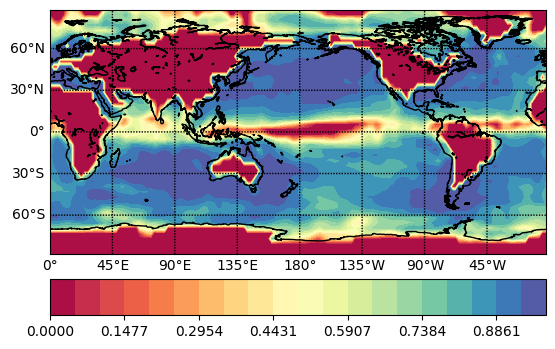

MSE_loss_map---


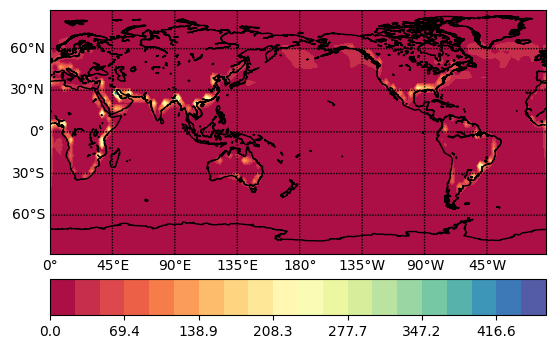

Mean generated map---


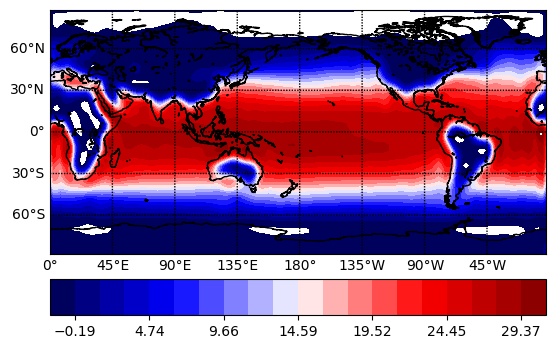

Mean original map---


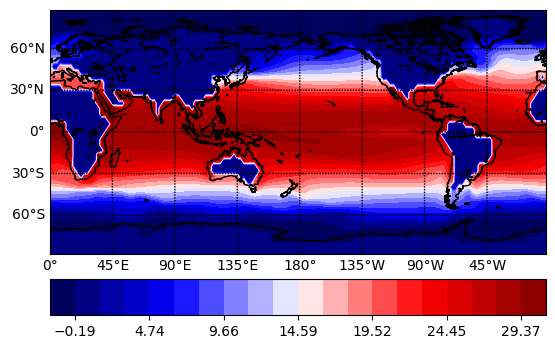

EOF


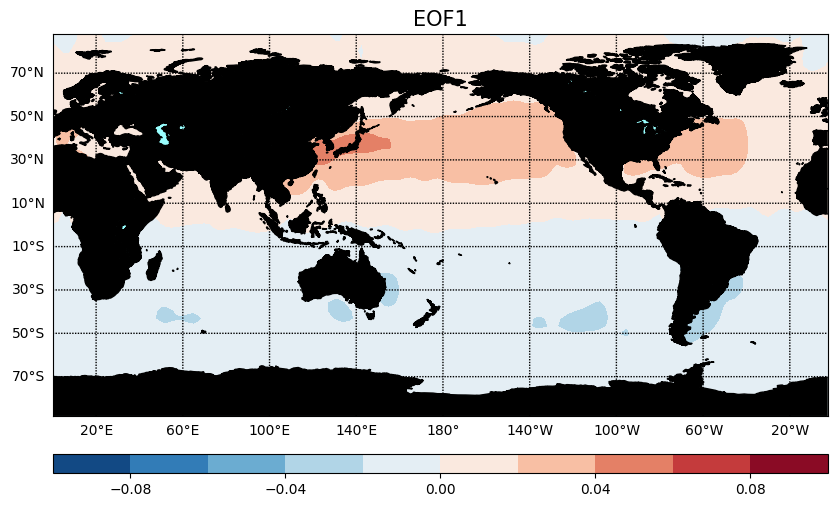

EOF original


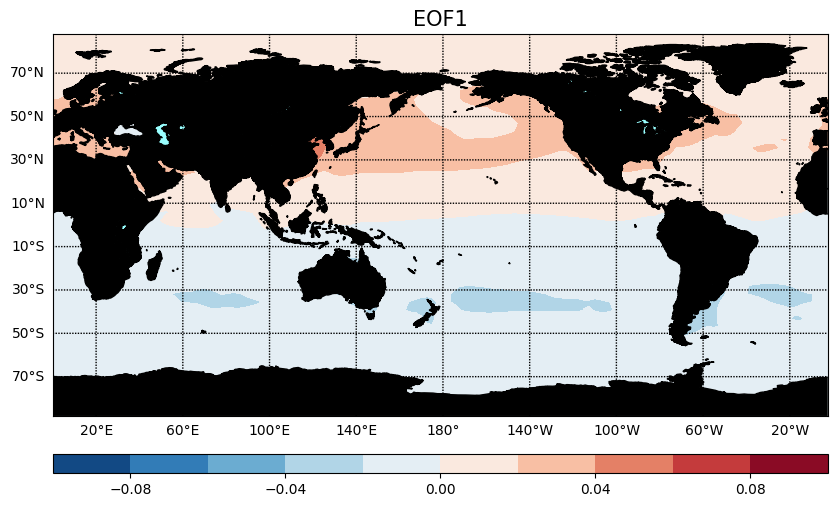

Spatial Corr= 0.9704011515714228
Spatial Loss= 9.657170791178942
-----------------------------------------------------------

Epoch 3: Train Loss: 58.768927, Val Loss: 35.380115, LR: 2.00e-04

Epoch 4: Train Loss: 30.577093, Val Loss: 20.999540, LR: 2.00e-04

For Test --->

Sample wise (/Temporal) SST corr=0.5941533055736188
Sample wise (/Temporal) SST loss=0.9452826495394051
Correlation_map---


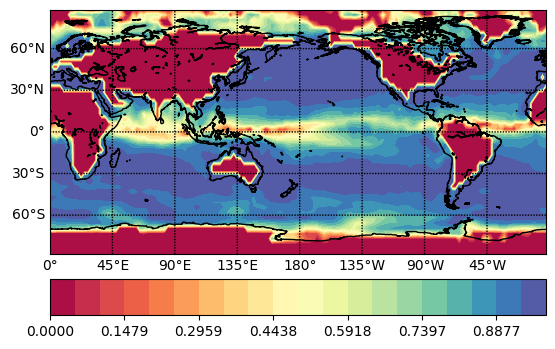

MSE_loss_map---


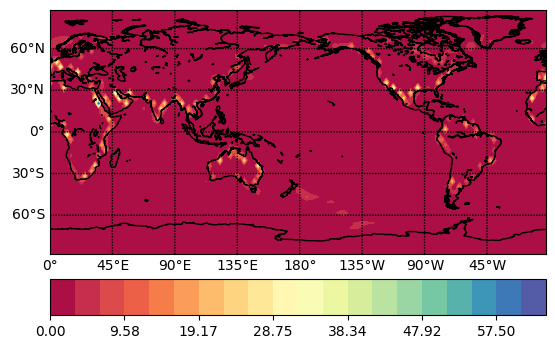

Mean generated map---


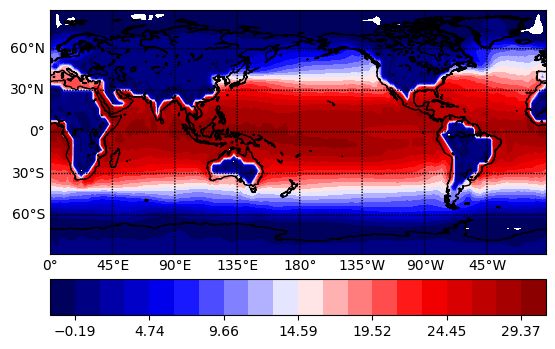

Mean original map---


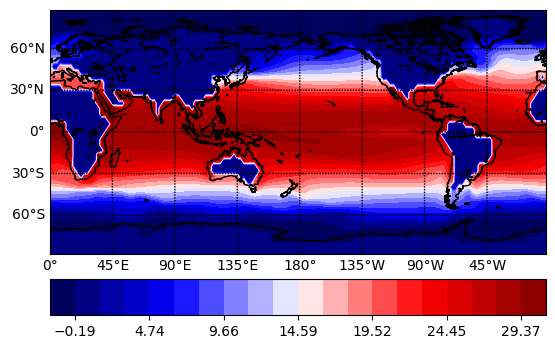

EOF


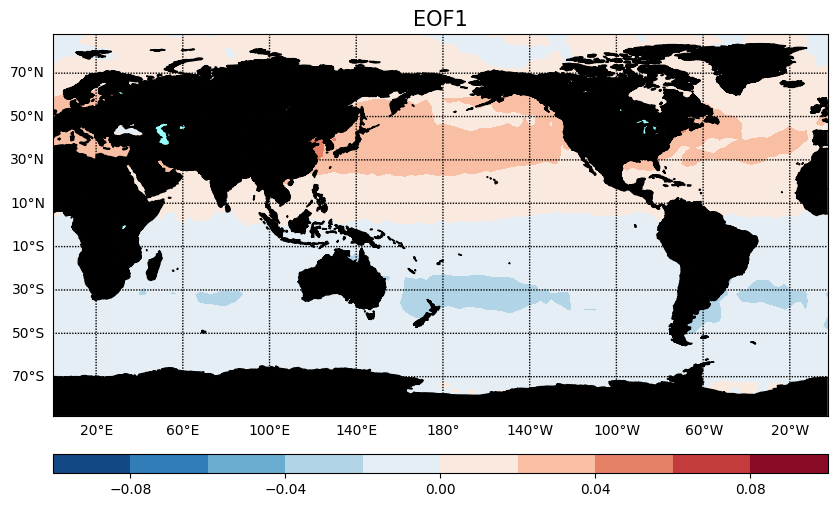

EOF original


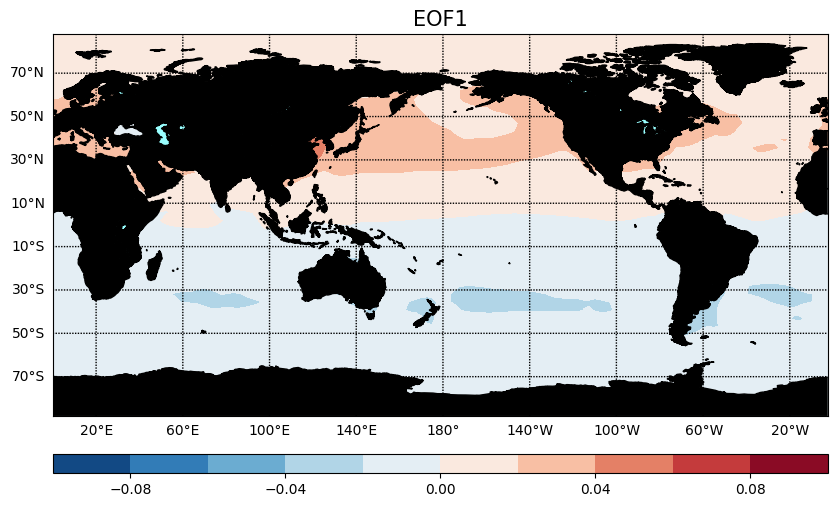

Spatial Corr= 0.9958607382141054
Spatial Loss= 1.2207902194932103
-----------------------------------------------------------

Epoch 5: Train Loss: 8.180744, Val Loss: 5.206417, LR: 2.00e-04


In [ ]:
from tqdm import tqdm

train_losses, val_losses = [], []

print("\nTraining VQ-VAE Model for Reconstruction Task...\n")

for epoch in range(5):

    model.train()
    running_loss = 0
    sample_count = 0
    for loader in train_loaders:
        for batch in loader:
            x = batch.to(device).float()
            optimizer.zero_grad()
            x_recon, vq_loss = model(x)
            recon_loss = F.mse_loss(x_recon, x)
            loss = recon_loss + vq_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            sample_count += x.size(0)
    train_loss = running_loss / sample_count
    train_losses.append(train_loss)



    model.eval()
    running_loss = 0
    sample_count = 0
    with torch.no_grad():
        for loader in val_loaders:
            for batch in loader:
                x = batch.to(device).float()
                x_recon, vq_loss = model(x)
                recon_loss = F.mse_loss(x_recon, x)
                loss = recon_loss + vq_loss
                running_loss += loss.item() * x.size(0)
                sample_count += x.size(0)
    val_loss = running_loss / sample_count
    val_losses.append(val_loss)

    scheduler.step(val_loss)


    print(f"\nEpoch {epoch+1}: "
          f"Train Loss: {train_loss:.6f}, "
          f"Val Loss: {val_loss:.6f}, "
          f"LR: {scheduler.get_last_lr()[0]:.2e}")


    # Save checkpoint every 10
    if (epoch+1) % 2 == 0:
        # torch.save(model.state_dict(), f"vqvae_epoch{epoch+1}.pth")
        # print("\nFor Training --->\n")
        # save_some_examples(model, train_loaders[0], None, folder=None)
        # print("\nFor Validation --->\n")
        # save_some_examples(model, val_loaders[0], None, folder=None)
        print("\nFor Test --->\n")
        save_some_examples(model, test_loaders[0], None, folder=None)

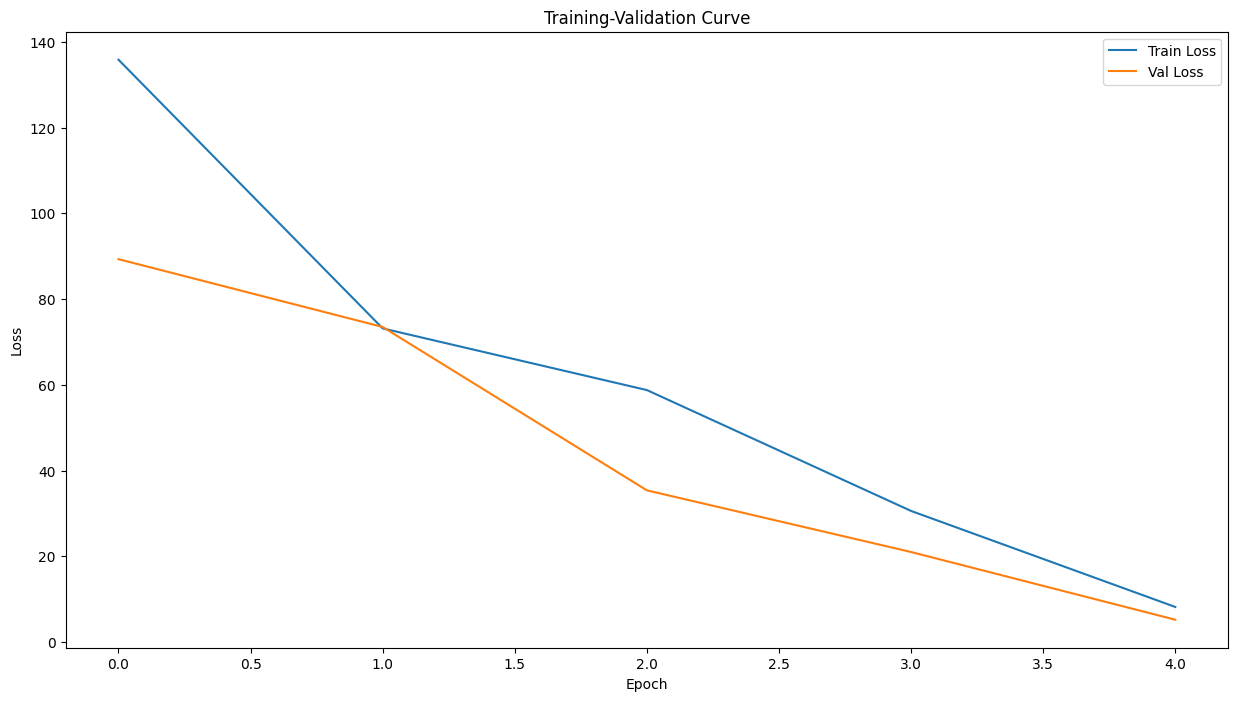

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training-Validation Curve")
plt.show()
